In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from sklearn.feature_selection import f_classif, f_regression, SelectKBest, chi2
from sklearn.ensemble          import IsolationForest

from sklearn.model_selection   import train_test_split
from sklearn.grid_search       import GridSearchCV
from sklearn.ensemble          import RandomForestRegressor
from sklearn.metrics           import mean_squared_error, mean_absolute_error, median_absolute_error

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import _pickle           as cPickle

import itertools
import argparse

from commonModel import loadData, FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS, TARGET_COLUMN

dataFileName  = "input/NizhnyNovgorodWithYear.csv"
allDataFrame = loadData( dataFileName, COLUMN_TYPE='NUMERICAL' )
allDataFrame.head(10)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


,price,longitude,latitude,total_square,number_of_rooms,number_of_floors,exploitation_start_year
0,2850000.0,44.075417,56.283864,43.0,1,17,2011.0
1,2600000.0,43.923782,56.310448,64.0,4,5,1974.0
2,2750000.0,44.064952,56.291499,50.0,2,5,1987.0
3,3700000.0,43.996545,56.317807,45.0,2,8,1969.0
4,4760000.0,43.943589,56.295000,105.0,4,9,1975.0
5,2960000.0,43.957846,56.333200,39.0,1,9,2008.0
6,3400000.0,44.073001,56.283864,44.0,1,17,2010.0
7,4000000.0,44.019955,56.321626,64.0,3,9,1969.0
8,2500000.0,44.058098,56.299376,45.3,2,9,1982.0
9,1600000.0,43.859067,56.251022,30.0,1,9,1984.0


In [2]:
allDataFrame.describe()

,price,longitude,latitude,total_square,number_of_rooms,number_of_floors,exploitation_start_year
count,1.656900e+04,16569.000000,16569.000000,16569.000000,16569.000000,16569.000000,16569.000000
mean,3.405087e+06,43.935783,56.299722,55.831132,2.128855,9.299354,1982.826544
std,1.864193e+06,0.079661,0.038840,23.918874,0.945455,5.016843,22.822819
min,5.500000e+05,43.739635,56.163158,13.000000,1.000000,1.000000,1898.000000
25%,2.250000e+06,43.865364,56.266592,40.200000,1.000000,5.000000,1966.000000
50%,2.950000e+06,43.933304,56.302557,51.000000,2.000000,9.000000,1981.000000
75%,4.050000e+06,44.005986,56.328204,66.300000,3.000000,10.000000,2005.000000
max,3.700000e+07,44.099151,56.391964,400.000000,9.000000,28.000000,2017.000000


In [3]:
import torch
import _pickle as cPickle
from commonModel import FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS

import warnings
warnings.filterwarnings('ignore')

NUMERICAL_COLUMNS = FLOAT_COLUMNS + INT_COLUMNS
testDataFrame = allDataFrame

FEATURES = list( testDataFrame.columns ); FEATURES.remove( TARGET_COLUMN )
COLUMNS  = list( testDataFrame.columns ); LABEL = TARGET_COLUMN;

index       = testDataFrame.index;
Y_dataFrame = testDataFrame    [[ TARGET_COLUMN ]];       
Y_values    = Y_dataFrame.values;
X_dataFrame = testDataFrame.drop( TARGET_COLUMN, axis=1); 
#X_dataFrame = X_dataFrame[['longitude','latitude','total_square','number_of_rooms','number_of_floors','exploitation_start_year']]
X_dataFrame = X_dataFrame[['longitude','latitude','total_square','number_of_rooms','number_of_floors','exploitation_start_year']]

X_values    = X_dataFrame.values
Y_values    = Y_values

device = torch.device('cpu')
#device = torch.device('cuda') # Uncomment this to run on GPU
Model = None
with open( "model.pkl", 'rb') as fid:
    Model = cPickle.load(fid)
preprocessorX = None
with open( 'preprocessorX.pkl', 'rb') as fid:
    preprocessorX = cPickle.load(fid)
preprocessorY = None
with open( 'preprocessorY.pkl', 'rb') as fid:
    preprocessorY = cPickle.load(fid)

X_numpy = preprocessorX.transform( X_values )
Y_numpy = preprocessorY.transform( Y_values )

X_torch = torch.from_numpy( X_numpy.astype( np.float32 ) ).to( device )
Y_torch = Model( X_torch )
Y_predict = Y_torch.detach().numpy()

print( "Errors on the test set" )
print( "mean square:     ", mean_squared_error   ( Y_numpy, Y_predict ) )
print( "mean absolute:   ", mean_absolute_error  ( Y_numpy, Y_predict ) )
print( "median_absolute: ", median_absolute_error( Y_numpy, Y_predict ) )

Y_predict = preprocessorY.inverse_transform( Y_predict ).ravel()
Y_values  = Y_values.ravel()

print( "Errors on the test set" )
print( "mean square:     ", mean_squared_error   ( Y_values, Y_predict ) )
print( "mean absolute:   ", mean_absolute_error  ( Y_values, Y_predict ) )
print( "median_absolute: ", median_absolute_error( Y_values, Y_predict ) )

Errors on the test set
mean square:      0.002683628500839188
mean absolute:    0.024550629292326914
median_absolute:  0.010186373520659542
Errors on the test set
mean square:      321773759391.2322
mean absolute:    268829.3934719959
median_absolute:  111540.75


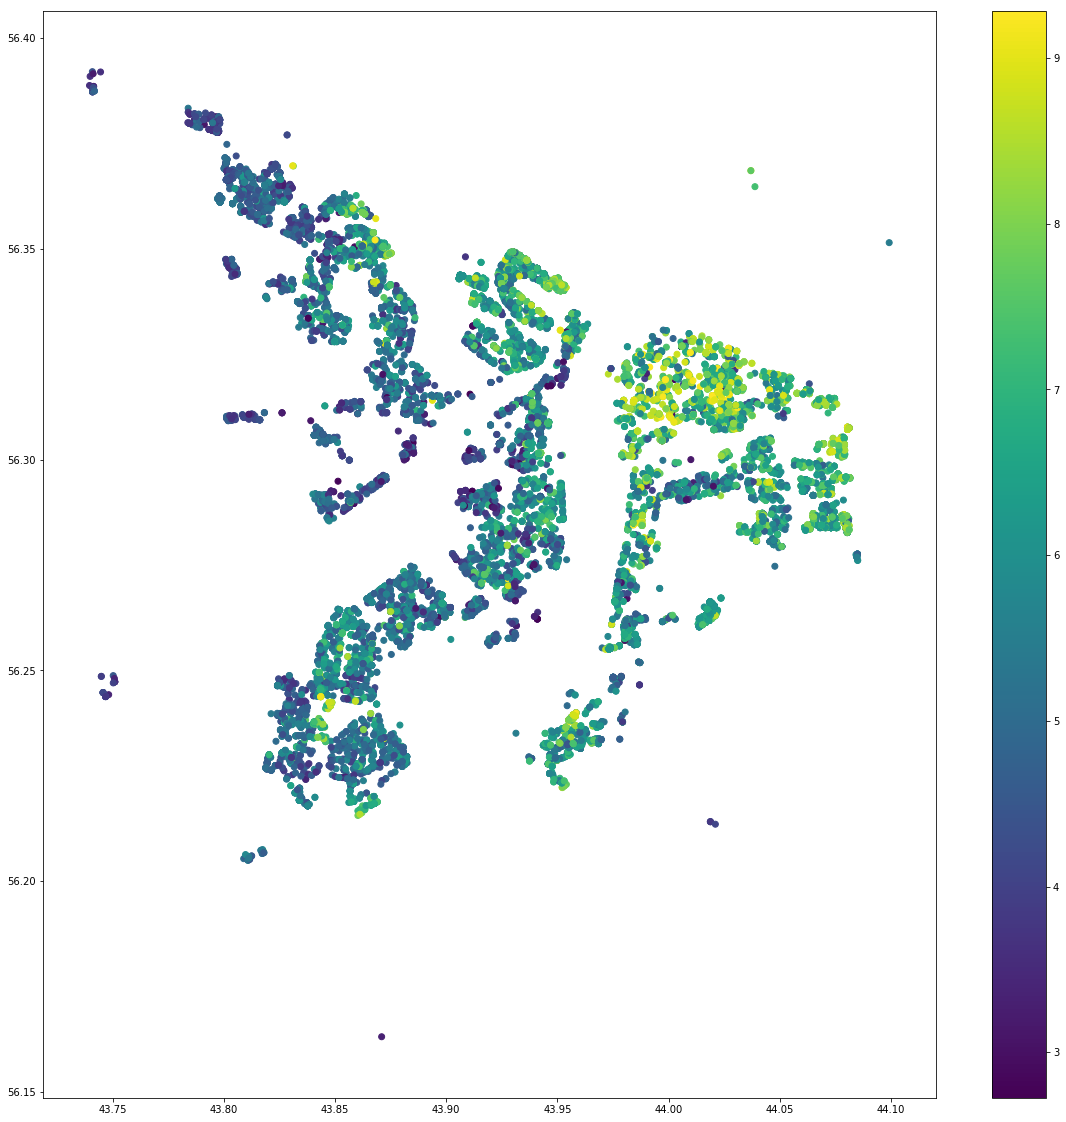

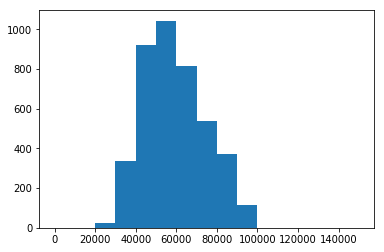

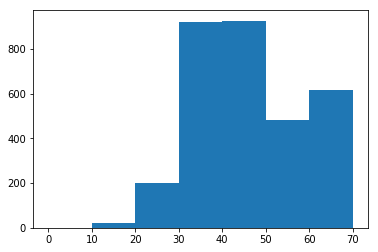

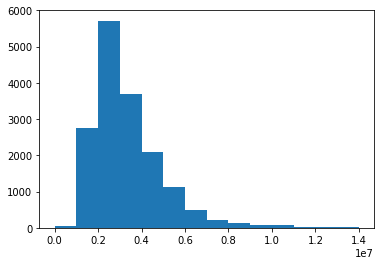

In [4]:
pricePerSquare       = allDataFrame['price']/allDataFrame['total_square']
TotalSquare          = allDataFrame['total_square']
Price                = allDataFrame['price']

pricePerSquareValues = pricePerSquare.values
TotalSquareValues    = TotalSquare.values
PriceValues          = Price.values

x = X_values[:,0]; y = X_values[:,1];

plt.figure(figsize=(20,20))
plt.scatter (x, y, c=pricePerSquareValues/10000  )
plt.colorbar()
plt.show()

Y_relErr = np.abs( Y_predict - Y_values )*100/Y_values
mask = Y_relErr > 10
pricePerSquareValues = pricePerSquareValues[ mask ]
TotalSquareValues    = TotalSquareValues   [ mask ]
Price                = Price               [ mask ]

bins = [0.,1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.,15.]
bins = [i * 1e4 for i in bins]
plt.hist( pricePerSquareValues, bins=bins )
plt.show()

bins = [0,10,20,30,40,50,60,70]
plt.hist( TotalSquareValues, bins=bins )
plt.show()

bins = [0.,1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.]
bins = [i * 1e6 for i in bins]
plt.hist( PriceValues      , bins=bins )
plt.show()


[3041371.2 2453563.  2725135.8 ... 1926951.4 2478393.5 3635445.2]
[2850000. 2600000. 2750000. ... 2650000. 2790000. 3841000.]
threshold =   2.5, good =       6719, bad =       9850, err = 0.5944836743315831
threshold =   5.0, good =       9379, bad =       7190, err = 0.43394290542579517
threshold =  10.0, good =      12408, bad =       4161, err = 0.25113163135976824
threshold =  15.0, good =      14070, bad =       2499, err = 0.15082382762991128


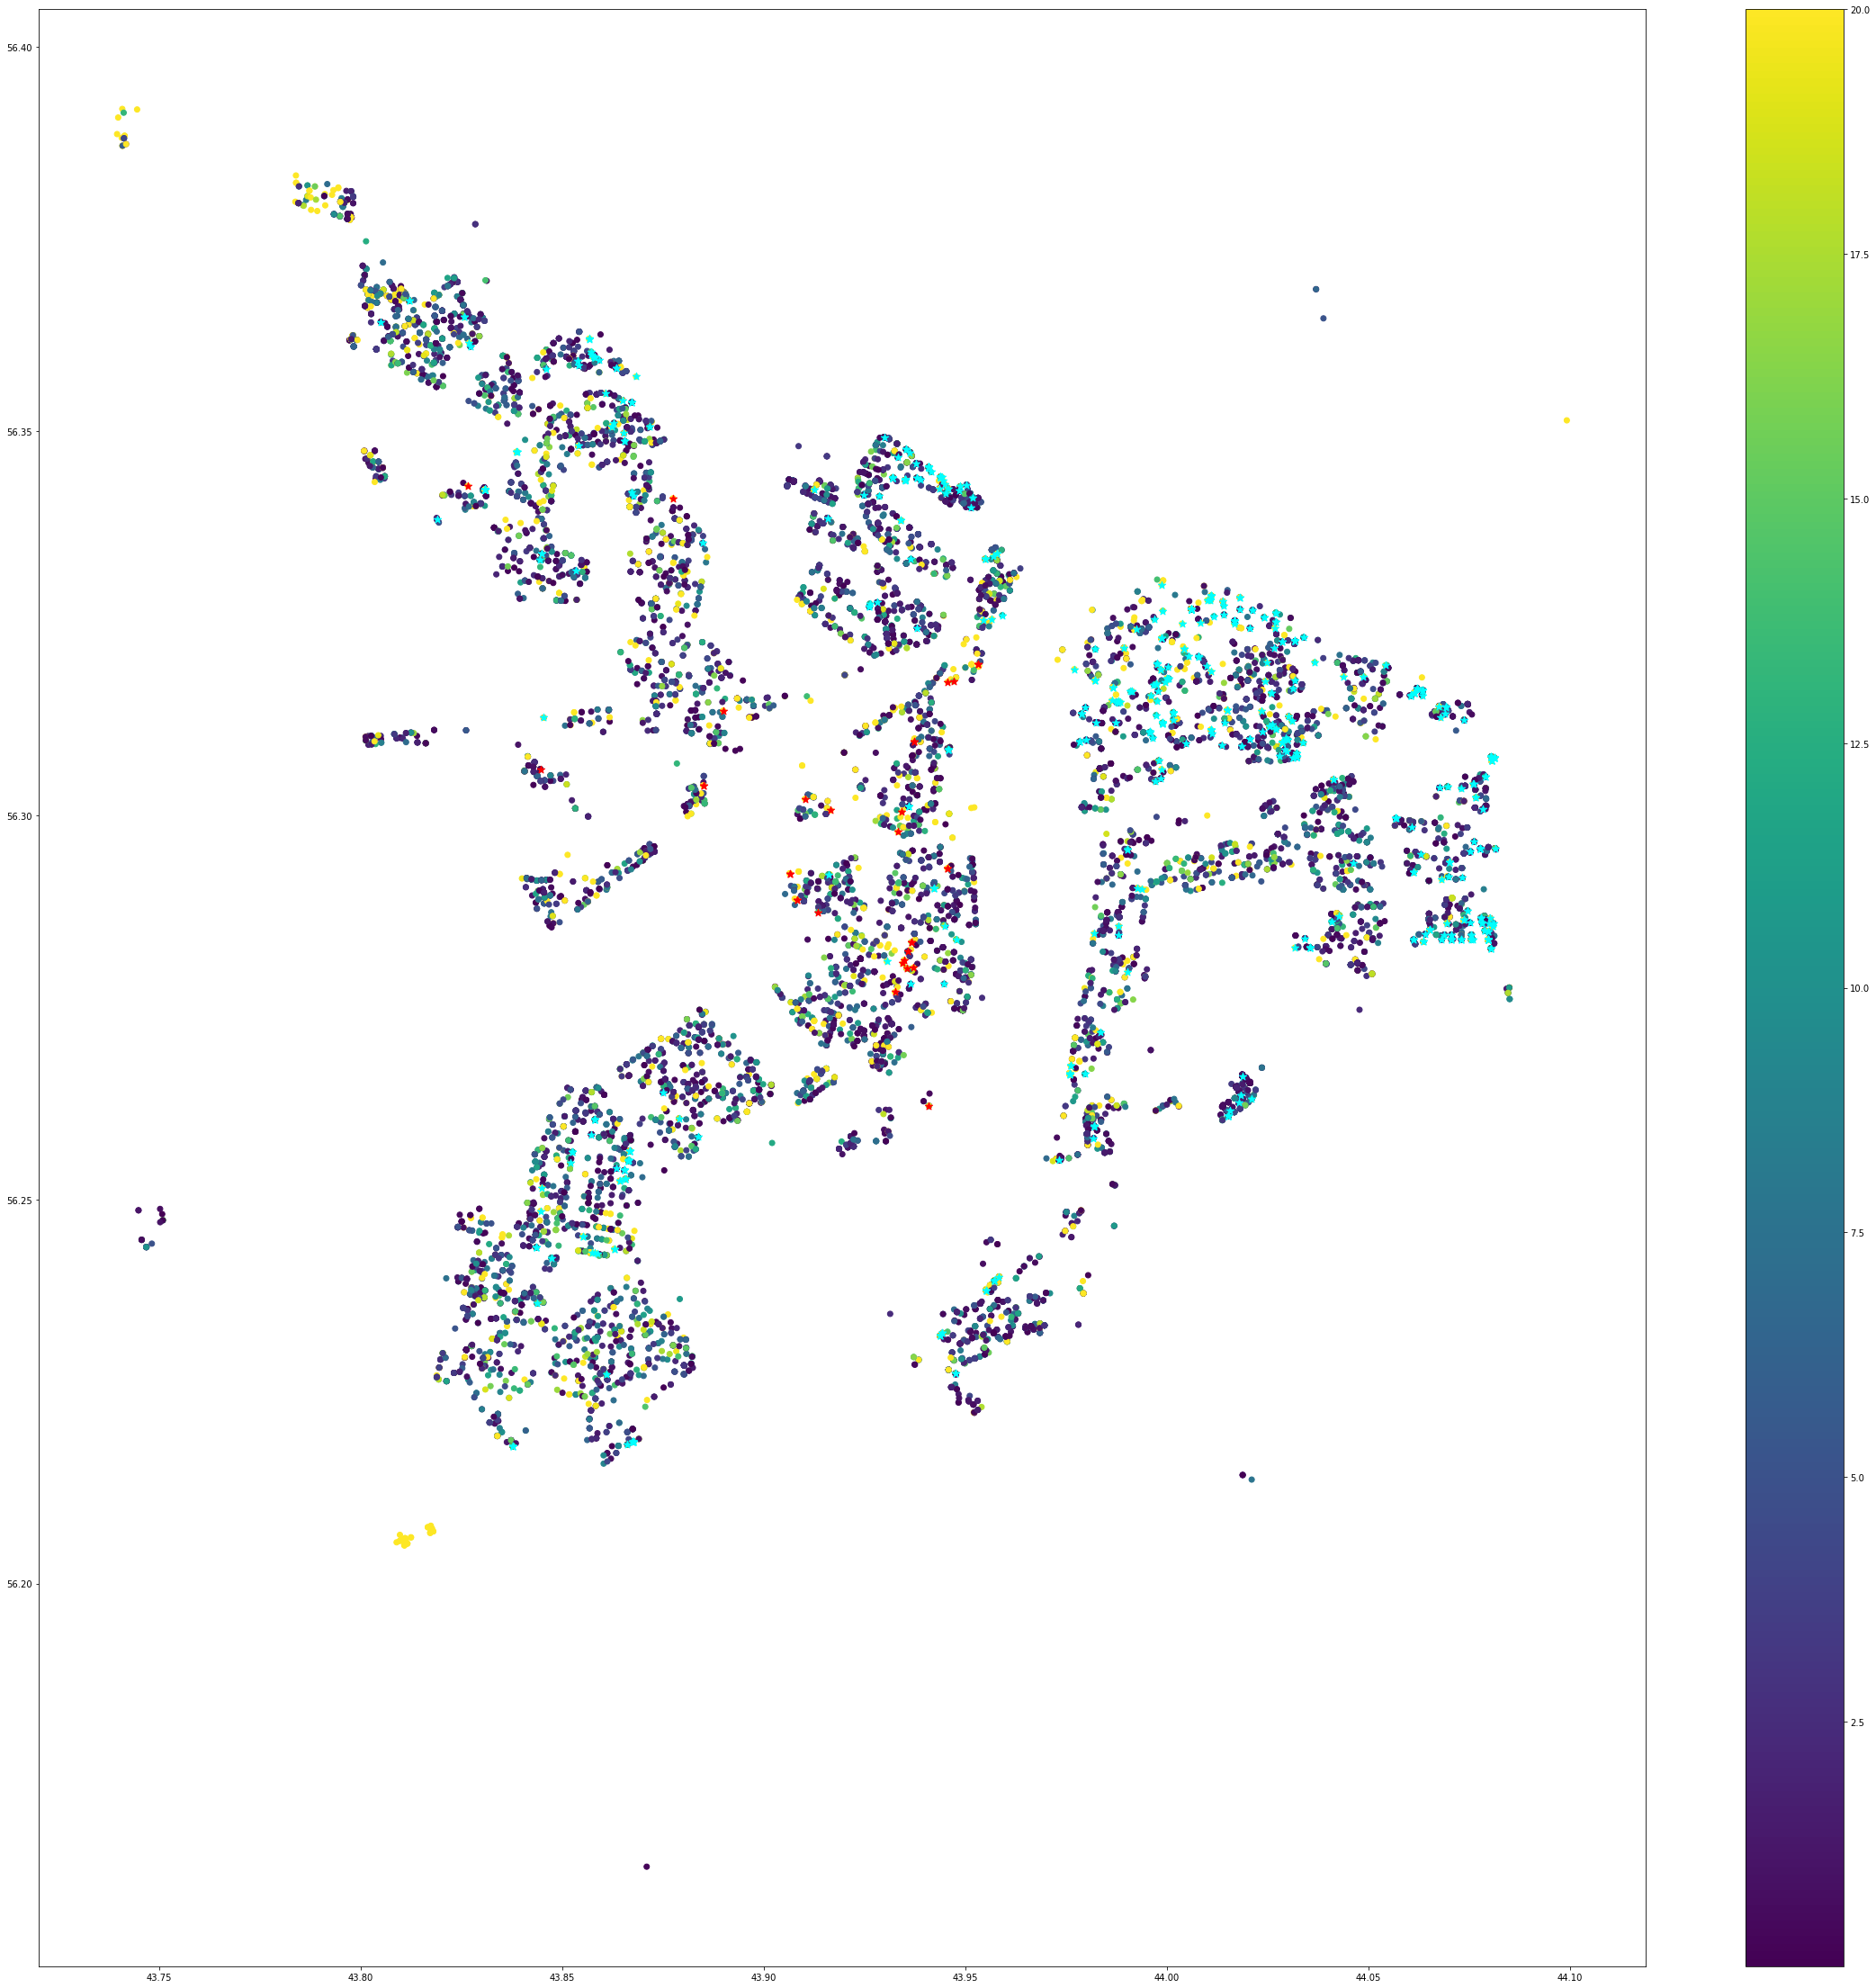

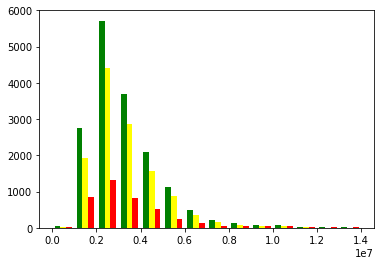

[  56. 2763. 5717. 3705. 2079. 1116.  494.  223.  128.   89.   75.   31.
   23.   20.]
[  23. 1921. 4409. 2873. 1563.  882.  360.  162.   83.   47.   37.   13.
    8.    8.]
[  33.  842. 1308.  832.  516.  234.  134.   61.   45.   42.   38.   18.
   15.   12.]


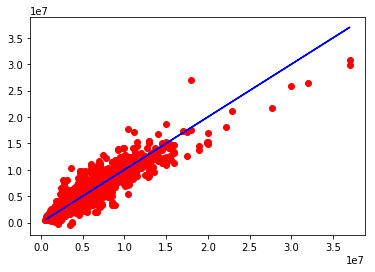

In [8]:
Y_predict = np.array( Y_predict )
Y_values  = np.array( Y_values  )

print( Y_predict )
print( Y_values  )

Y_relErr = np.abs( Y_predict - Y_values )*100/Y_values
for threshold in [ 2.5, 5.0, 10.0, 15.0 ]:
    bad_s  = np.sum( ( Y_relErr  > threshold ).astype( np.int ) )
    good_s = np.sum( ( Y_relErr <= threshold ).astype( np.int ) )
    print("threshold = {:5}, good = {:10}, bad = {:10}, err = {:4}".format( threshold, good_s, bad_s, bad_s/(good_s+bad_s)) )
x =  X_values[:,0]; y = X_values[:,1]; c = np.minimum(  Y_relErr, 20 );

plt.figure(figsize=(40,40))
plt.scatter (x, y, c=c  )
plt.colorbar()

mask = ( Y_values < 1e6 ) & ( Y_relErr > 10 )
x_low = X_values[mask,0]; y_low = X_values[mask,1]; c_low = 'red'
plt.scatter (x_low, y_low, c=c_low, marker="*", s=75  )

mask = ( Y_values > 5e6 ) & ( Y_relErr > 10 )
x_high = X_values[mask,0]; y_high = X_values[mask,1]; c_high = 'aqua'
plt.scatter (x_high, y_high, c=c_high, marker="*", s=75  )
plt.show    ()

threshold = 10
allTestDataValues  = testDataFrame.price.values
mask = Y_relErr >  threshold
badTestDataValues = testDataFrame[ mask ].price.values
mask = Y_relErr <= threshold
goodTestDataValues = testDataFrame[ mask ].price.values

bins = [0.,1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.]
bins = [i * 1e6 for i in bins]

n = plt.hist([ allTestDataValues, goodTestDataValues, badTestDataValues ], bins=bins, histtype='bar', color=['green','yellow','red'])
plt.show()

print( n[0][0] )
print( n[0][1] )
print( n[0][2] )

plt.scatter(Y_values,Y_predict, color='red' )
plt.plot   (Y_values,Y_values , color='blue')
plt.show   ()

In [6]:
from commonModel import MAX_LONGITUDE, MIN_LONGITUDE, MAX_LATITUDE, MIN_LATITUDE

import warnings
warnings.filterwarnings('ignore')

topK = 10

eps_x = ( MAX_LONGITUDE - MIN_LONGITUDE )*0.001
eps_y = ( MAX_LATITUDE  - MIN_LATITUDE  )*0.001
eps   = min( eps_x, eps_y )

topRelErrIndices = Y_relErr.argsort()[-topK:][::-1]
for i in topRelErrIndices :
    base_row = allDataFrame.iloc[ i ]
    base_x = base_row.longitude 
    base_y = base_row.latitude  
    print("BASE record")
    print( base_row )
    
    for index, cand_row in allDataFrame.iterrows():
        cand_x = cand_row.longitude
        cand_y = cand_row.latitude
        
        distance = np.sqrt( (cand_x-base_x)*(cand_x-base_x) + (cand_y-base_y)*(cand_y-base_y) )
        if distance < eps :
            print("CLOSEST record")
            print( cand_row )
    print("")
    

BASE record
price                      2.600000e+06
longitude                  4.400780e+01
latitude                   5.632769e+01
total_square               7.600000e+01
number_of_rooms            5.000000e+00
number_of_floors           4.000000e+00
exploitation_start_year    1.917000e+03
Name: 47570, dtype: float64
CLOSEST record
price                      2.600000e+06
longitude                  4.400780e+01
latitude                   5.632769e+01
total_square               7.600000e+01
number_of_rooms            5.000000e+00
number_of_floors           4.000000e+00
exploitation_start_year    1.917000e+03
Name: 47570, dtype: float64

BASE record
price                      3.650000e+06
longitude                  4.385136e+01
latitude                   5.629487e+01
total_square               1.300000e+02
number_of_rooms            4.000000e+00
number_of_floors           2.000000e+00
exploitation_start_year    1.950000e+03
Name: 26956, dtype: float64
CLOSEST record
price                

Name: 4841, dtype: float64
CLOSEST record
price                      3.550000e+06
longitude                  4.400599e+01
latitude                   5.632689e+01
total_square               6.290000e+01
number_of_rooms            3.000000e+00
number_of_floors           9.000000e+00
exploitation_start_year    1.980000e+03
Name: 4842, dtype: float64
CLOSEST record
price                      2.650000e+06
longitude                  4.400599e+01
latitude                   5.632689e+01
total_square               3.000000e+01
number_of_rooms            1.000000e+00
number_of_floors           9.000000e+00
exploitation_start_year    1.986000e+03
Name: 4848, dtype: float64
CLOSEST record
price                      2.060000e+06
longitude                  4.400599e+01
latitude                   5.632689e+01
total_square               4.700000e+01
number_of_rooms            2.000000e+00
number_of_floors           5.000000e+00
exploitation_start_year    1.966000e+03
Name: 5062, dtype: float64
CLOSEST

CLOSEST record
price                      1.570000e+06
longitude                  4.400599e+01
latitude                   5.632689e+01
total_square               3.400000e+01
number_of_rooms            1.000000e+00
number_of_floors           9.000000e+00
exploitation_start_year    1.985000e+03
Name: 13755, dtype: float64
CLOSEST record
price                      2.600000e+06
longitude                  4.400599e+01
latitude                   5.632689e+01
total_square               3.090000e+01
number_of_rooms            1.000000e+00
number_of_floors           5.000000e+00
exploitation_start_year    1.960000e+03
Name: 13767, dtype: float64
CLOSEST record
price                      3.050000e+06
longitude                  4.400599e+01
latitude                   5.632689e+01
total_square               4.130000e+01
number_of_rooms            2.000000e+00
number_of_floors           5.000000e+00
exploitation_start_year    1.963000e+03
Name: 14000, dtype: float64
CLOSEST record
price           

CLOSEST record
price                      4.120000e+06
longitude                  4.400599e+01
latitude                   5.632689e+01
total_square               6.440000e+01
number_of_rooms            2.000000e+00
number_of_floors           9.000000e+00
exploitation_start_year    1.986000e+03
Name: 22311, dtype: float64
CLOSEST record
price                      2.780000e+06
longitude                  4.400599e+01
latitude                   5.632689e+01
total_square               4.200000e+01
number_of_rooms            2.000000e+00
number_of_floors           9.000000e+00
exploitation_start_year    1.974000e+03
Name: 22349, dtype: float64
CLOSEST record
price                      3.950000e+06
longitude                  4.400599e+01
latitude                   5.632689e+01
total_square               7.600000e+01
number_of_rooms            3.000000e+00
number_of_floors           6.000000e+00
exploitation_start_year    1.956000e+03
Name: 22350, dtype: float64
CLOSEST record
price           

Name: 30762, dtype: float64
CLOSEST record
price                      2.830000e+06
longitude                  4.400599e+01
latitude                   5.632689e+01
total_square               4.700000e+01
number_of_rooms            2.000000e+00
number_of_floors           9.000000e+00
exploitation_start_year    1.986000e+03
Name: 30814, dtype: float64
CLOSEST record
price                      1.780000e+06
longitude                  4.400599e+01
latitude                   5.632689e+01
total_square               2.210000e+01
number_of_rooms            1.000000e+00
number_of_floors           5.000000e+00
exploitation_start_year    1.969000e+03
Name: 30847, dtype: float64
CLOSEST record
price                      1.950000e+06
longitude                  4.400599e+01
latitude                   5.632689e+01
total_square               3.100000e+01
number_of_rooms            2.000000e+00
number_of_floors           3.000000e+00
exploitation_start_year    1.963000e+03
Name: 31002, dtype: float64
CLO

price                      2.050000e+06
longitude                  4.400599e+01
latitude                   5.632689e+01
total_square               3.850000e+01
number_of_rooms            2.000000e+00
number_of_floors           5.000000e+00
exploitation_start_year    1.973000e+03
Name: 35392, dtype: float64
CLOSEST record
price                      1.450000e+06
longitude                  4.400599e+01
latitude                   5.632689e+01
total_square               3.150000e+01
number_of_rooms            1.000000e+00
number_of_floors           5.000000e+00
exploitation_start_year    1.965000e+03
Name: 35393, dtype: float64
CLOSEST record
price                      2.500000e+06
longitude                  4.400599e+01
latitude                   5.632689e+01
total_square               7.500000e+01
number_of_rooms            3.000000e+00
number_of_floors           4.000000e+00
exploitation_start_year    1.969000e+03
Name: 35544, dtype: float64
CLOSEST record
price                      2.10

CLOSEST record
price                      2.150000e+06
longitude                  4.400599e+01
latitude                   5.632689e+01
total_square               4.370000e+01
number_of_rooms            2.000000e+00
number_of_floors           6.000000e+00
exploitation_start_year    1.971000e+03
Name: 45748, dtype: float64
CLOSEST record
price                      1.450000e+06
longitude                  4.400599e+01
latitude                   5.632689e+01
total_square               3.860000e+01
number_of_rooms            2.000000e+00
number_of_floors           2.000000e+00
exploitation_start_year    1.958000e+03
Name: 45749, dtype: float64
CLOSEST record
price                      2.590000e+06
longitude                  4.400599e+01
latitude                   5.632689e+01
total_square               5.500000e+01
number_of_rooms            2.000000e+00
number_of_floors           5.000000e+00
exploitation_start_year    1.959000e+03
Name: 45762, dtype: float64
CLOSEST record
price           

CLOSEST record
price                      3.300000e+06
longitude                  4.400599e+01
latitude                   5.632689e+01
total_square               4.720000e+01
number_of_rooms            1.000000e+00
number_of_floors           9.000000e+00
exploitation_start_year    2.017000e+03
Name: 57799, dtype: float64
CLOSEST record
price                      2.500000e+06
longitude                  4.400599e+01
latitude                   5.632689e+01
total_square               4.400000e+01
number_of_rooms            3.000000e+00
number_of_floors           5.000000e+00
exploitation_start_year    1.961000e+03
Name: 57807, dtype: float64
CLOSEST record
price                      8.600000e+06
longitude                  4.400599e+01
latitude                   5.632689e+01
total_square               9.930000e+01
number_of_rooms            3.000000e+00
number_of_floors           1.900000e+01
exploitation_start_year    2.011000e+03
Name: 58414, dtype: float64
CLOSEST record
price           


BASE record
price                      1.850000e+06
longitude                  4.385417e+01
latitude                   5.635861e+01
total_square               5.900000e+01
number_of_rooms            2.000000e+00
number_of_floors           1.000000e+01
exploitation_start_year    2.011000e+03
Name: 53747, dtype: float64
CLOSEST record
price                      7.050000e+06
longitude                  4.385417e+01
latitude                   5.635861e+01
total_square               7.700000e+01
number_of_rooms            3.000000e+00
number_of_floors           1.000000e+01
exploitation_start_year    2.011000e+03
Name: 46545, dtype: float64
CLOSEST record
price                      3.300000e+06
longitude                  4.385417e+01
latitude                   5.635861e+01
total_square               4.060000e+01
number_of_rooms            1.000000e+00
number_of_floors           1.000000e+01
exploitation_start_year    2.011000e+03
Name: 46578, dtype: float64
CLOSEST record
price             